This code comes from https://github.com/vispy/vispy/blob/master/examples/demo/gloo/fireworks.py and contains my comments as I am trying to understand it.

I happened across the need to learn how to code up data-driven visualizations in VisPy. VisPy is  a cutting edge wrapper API for OpenGL, which is a graphics library. I want to program an 2D plot of cells in a calcium imaging experiment and color them in time according to their activity. Later on, I would like to select cells from specific ensembles of co-activating neurons, calculated using the EnsemblePursuit algorithm, so that you can see how these cells co-fire. 


Okay so we first generate a (65,65) image of a circle with radius 32. 

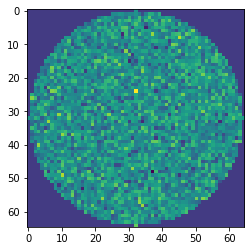

In [2]:
import time
import numpy as np
from vispy import gloo, app
import matplotlib.pyplot as plt
%matplotlib inline

# import vispy
# vispy.use('pyside', 'es2')


# Create a texture
radius = 32
im1 = np.random.normal(
    0.8, 0.3, (radius * 2 + 1, radius * 2 + 1)).astype(np.float32)

# Mask it with a disk
L = np.linspace(-radius, radius, 2 * radius + 1)
(X, Y) = np.meshgrid(L, L)
im1 *= np.array((X ** 2 + Y ** 2) <= radius * radius, dtype='float32')

plt.imshow(im1)
plt.show()



Next we create a data array which holds how long a cell  lasts before it becomes transparent.The array also has start position and end position. Easy enough.

In [ ]:
# Set number of particles, you should be able to scale this to 100000
N = 10000

# Create vertex data container
data = np.zeros(N, [('a_lifetime', np.float32),
                    ('a_startPosition', np.float32, 3),
                    ('a_endPosition', np.float32, 3)])


Next comes the vertex shader! How exciting! Alright so what are these uniform attribute and varying variables?

From https://www.opengl.org/sdk/docs/tutorials/ClockworkCoders/attributes.php we get:
"Vertex attributes are used to communicate from "outside" to the vertex shader. Unlike uniform variables, values are provided per vertex (and not globally for all vertices). There are built-in vertex attributes like the normal or the position, or you can specify your own vertex attribute like a tangent or another custom value. Attributes can't be defined in the fragment shader."
Ha it's exactly the variables coming from the data variable in the previous cell! Cool.
"Uniform variables are used to communicate with your vertex or fragment shader from "outside". Uniform variables are read-only and have the same value among all processed vertices. You can only change them within your C++ program." 
Replace C++ with Python then. Okay u_time is a global time. But what is u_centerPosition? Looking forward at the code at each reinitialization it is recomputed and passed to the shader. It is just one triple of x,y,z coordinates. It looks like an initial condition for the firework. It's where the circles start out.

What is gl_Position?

https://learnopengl.com/Advanced-OpenGL/Advanced-GLSL

"Shaders are minimal, if we need data from any other source outside the current shader we'll have to pass data around. We learned to do this via vertex attributes, uniforms and samplers. There are however a few extra variables defined by GLSL prefixed with gl_ that give us an extra means to gather and/or write data. We've already seen two of them in the tutorials so far: gl_Position that is the output vector of the vertex shader."

Okay so u_time is passed from the outside to the shader and is a global clock ticking. Start and end position is what we get from outside the program. Each vertex has it's own start and end position. As far as I can understand the code interpolates between start and end.

There's still a bunch of stuff I don't understand. u_time is updated in the on_draw function in the canvas class. There doesn't seem to be for loop for running the visualization. Yet it still behaves as though there is a for loop. 

Start and end position get assigned at the beginning of each firework. The thing that changes is the u_time. I get it. At each time step you go from the startPosition by an increment equal to endPosition.

y is made quadratic in time so the firework curls. 

In [4]:
VERT_SHADER = """
uniform float u_time;
uniform vec3 u_centerPosition;
attribute float a_lifetime;
attribute vec3 a_startPosition;
attribute vec3 a_endPosition;
varying float v_lifetime;

void main () {
    if (u_time <= a_lifetime)
    {
        gl_Position.xyz = a_startPosition + (u_time * a_endPosition);
        gl_Position.xyz += u_centerPosition;
        gl_Position.y -= 1.0 * u_time * u_time;
        gl_Position.w = 1.0;
    }
    else
        gl_Position = vec4(-1000, -1000, 0, 0);

    v_lifetime = 1.0 - (u_time / a_lifetime);
    v_lifetime = clamp(v_lifetime, 0.0, 1.0);
    gl_PointSize = (v_lifetime * v_lifetime) * 40.0;
}
"""
#Down the line
data['a_lifetime'] = np.random.normal(2.0, 0.5, (N,))
data['a_startPosition'] = np.random.normal(0.0, 0.2, (N, 3))
data['a_endPosition'] = np.random.normal(0.0, 1.2, (N, 3))


Next comes the fragment shader. 
texture1 is a common global variable that stores the texture. 
What is sampler2D?
https://thebookofshaders.com/glossary/?search=texture2D
"sampler specifies the sampler to which the texture from which texels will be retrieved is bound."

In [ ]:
FRAG_SHADER = """
#version 120
precision highp float;
uniform sampler2D texture1;
uniform vec4 u_color;
varying float v_lifetime;
uniform highp sampler2D s_texture;

void main()
{
    highp vec4 texColor;
    texColor = texture2D(s_texture, gl_PointCoord);
    gl_FragColor = vec4(u_color) * texColor;
    gl_FragColor.a *= v_lifetime;
}
"""

Okay, that's it for this post. Going to review programming different shaders in further posts. 